# Adam + LBFGS for m = 10

In [1]:
# !pip install pandas --break-system-packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

In [3]:
# --- Define PINN ---
class PINN(nn.Module):
    def __init__(self, num_layers, num_neurons, N_fields):
        super(PINN, self).__init__()
        self.N_fields = N_fields
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(1, num_neurons))
        for _ in range(num_layers):
            self.layers.append(nn.Linear(num_neurons, num_neurons))
        self.layers.append(nn.Linear(num_neurons, 1 + N_fields))

    def forward(self, t):
        x = t
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        a = torch.nn.functional.softplus(x[:, 0:1])
        a = torch.clamp(a, min=1e-6)
        phi = x[:, 1:]
        return a, phi

# --- Define ODE system ---
def ode_system(t, y, m_vec, rho_m0, rho_r0, rho_l0):
    N = len(m_vec)
    a = y[0]
    phi = y[1:N+1]
    phi_dot = y[N+1:2*N+1]

    kinetic = 0.5 * np.sum((phi_dot * a)**2)
    potential = 0.5 * np.sum((m_vec**2) * (phi * a)**2)

    H = np.sqrt((1/3) * (kinetic + potential + rho_m0 / a + rho_r0 / a**2 + rho_l0 * a**2))
    a_dot = H
    phi_ddot = - np.sqrt(3) * np.sqrt(
        0.5 * np.sum(phi_dot**2) +
        0.5 * np.sum((m_vec**2) * phi**2) +
        rho_m0 / a**3 + rho_r0 / a**4 + rho_l0
    ) * phi_dot - (m_vec**2) * phi

    dydt = np.zeros_like(y)
    dydt[0] = a_dot
    dydt[1:N+1] = phi_dot
    dydt[N+1:2*N+1] = phi_ddot
    return dydt

# --- Settings ---
###################
###################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

N_fields = 1
#m_vec = np.linspace(1.0, 50.0, N_fields)
m_vec = np.array([10.0])
rho_m0 = 0.81
rho_r0 = 0.00027138
rho_l0 = 2.19

phi0_np = np.array([1.0]*N_fields)
phi_dot0_np = np.array([0.0]*N_fields)
a0_np = 1e-8
y0 = np.concatenate([[a0_np], phi0_np, phi_dot0_np])

t_span = (0.0, 1.0)
t_eval = np.logspace(-8, 0, 1000).astype(np.float32)

# --- Solve ODE ---
print("Solving ODE...")
start_ode = time.time()
sol = solve_ivp(ode_system, t_span, y0, t_eval=t_eval, args=(m_vec, rho_m0, rho_r0, rho_l0), method='RK45')
end_ode = time.time()
ode_time = end_ode - start_ode
print(f"ODE solve time: {ode_time:.4f} seconds")

a_sol = sol.y[0, :]
phi_sol = sol.y[1:1+N_fields, :]

# --- Train PINN ---
model = PINN(num_layers=1, num_neurons=100, N_fields=N_fields).to(device)
m_vec_torch = torch.tensor(m_vec, dtype=torch.float32, device=device)
phi0 = torch.tensor(phi0_np.reshape(1, -1), device=device)
a0 = torch.tensor([[a0_np]], device=device)
t0 = torch.tensor([[0.0]], device=device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)

# --- Define losses ---
def physics_loss(model, t):
    a, phi = model(t)
    a_t = torch.autograd.grad(a, t, grad_outputs=torch.ones_like(a), create_graph=True)[0]
    phi_t = torch.autograd.grad(phi, t, grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_tt = torch.autograd.grad(phi_t, t, grad_outputs=torch.ones_like(phi_t), create_graph=True)[0]

    kinetic = 0.5 * torch.sum((phi_t**2) * (a**2), dim=1, keepdim=True)
    potential = 0.5 * torch.sum((m_vec_torch**2) * (phi**2) * (a**2), dim=1, keepdim=True)
    Friedmann = a_t - torch.sqrt((1/3)*(kinetic + potential + rho_m0/a + rho_r0/a**2 + rho_l0 * a**2) + 1e-12)

    sqsumrho = torch.sqrt(torch.full_like(t, 3.0)) * torch.sqrt(
        0.5 * torch.sum(phi_t**2, dim=1, keepdim=True) +
        0.5 * torch.sum((m_vec_torch**2) * phi**2, dim=1, keepdim=True) +
        rho_m0/a**3 + rho_r0/a**4 + rho_l0 + 1e-12
    )
    KG = phi_tt + sqsumrho * phi_t + phi * (m_vec_torch**2)

    return torch.mean(Friedmann**2) + torch.mean(KG**2)

a_weight = 10.0
phi_weight = 1

def initial_loss(model):
    a_pred0, phi_pred0 = model(t0)
    return a_weight * torch.mean((a_pred0 - a0)**2) + phi_weight * torch.mean((phi_pred0 - phi0)**2)



Using device: cuda
Solving ODE...
ODE solve time: 0.0096 seconds


In [4]:

N_f = 1000
max_epochs_adam = 10000
results = []

physics_weights = np.linspace(5,15,num=5)
ic_weights = np.linspace(150,300,num=5)

for pw in physics_weights:
    for iw in ic_weights:
        print(f"\nTraining with physics_weight={pw}, ic_weight={iw}")
        
        # --- Train with Adam ---
        print("Training PINN...")
        start_train = time.time()

        loss_history = []
        physics_loss_history = []
        ic_loss_history = []

        for epoch in range(max_epochs_adam):
            t_f = torch.linspace(0.0, 1.0, N_f, device=device).reshape(-1, 1).requires_grad_()
            optimizer.zero_grad()
            loss_physics_val = physics_loss(model, t_f)
            loss_ic_val = initial_loss(model)
            loss = pw * loss_physics_val + iw * loss_ic_val
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_history.append(loss.item())
            physics_loss_history.append(loss_physics_val.item())
            ic_loss_history.append(loss_ic_val.item())
#             if epoch % 1000 == 0:
#                 print(f"[Adam] Epoch {epoch}, Loss: {loss.item():.3e}")

        end_train = time.time()
        pinn_time = end_train - start_train
        print(f"PINN training time: {pinn_time:.2f} seconds")

        # --- LBFGS optimization ---
        print("Starting LBFGS optimization...")

        optimizer_lbfgs = torch.optim.LBFGS(
            model.parameters(),
            lr=1.0,
            max_iter=5000,
            tolerance_grad=1e-9,
            tolerance_change=1e-9,
            history_size=50,
            line_search_fn='strong_wolfe'
        )

        def closure():
            optimizer_lbfgs.zero_grad()
            t_f = torch.linspace(0.0, 1.0, N_f, device=device).reshape(-1, 1).requires_grad_()
            loss_physics_val = physics_loss(model, t_f)
            loss_ic_val = initial_loss(model)
            loss = pw * loss_physics_val + iw * loss_ic_val
            loss.backward()
            return loss

        start_lbfgs = time.time()
        optimizer_lbfgs.step(closure)
        end_lbfgs = time.time()

        print(f"LBFGS optimization time: {end_lbfgs - start_lbfgs:.2f} seconds")


        # --- Evaluate model ---
        t_plot = torch.tensor(t_eval, device=device).reshape(-1, 1).requires_grad_(True)
        a_pred, phi_pred = model(t_plot)
        a_pred = a_pred.detach().cpu().numpy().flatten()
        phi_pred = phi_pred.detach().cpu().numpy().T
        
        # --- Compute absolute error ---
        error_a = np.abs(a_sol - a_pred)
        error_phi = np.abs(phi_sol - phi_pred)
        mae_a = np.mean(error_a)
        mae_phi = np.mean(error_phi, axis=1)

        results.append({
            'physics_weight': pw,
            'ic_weight': iw,
            'mae_a': mae_a,
            'mae_phi': mae_phi
        })
        
# Save results
df = pd.DataFrame(results)
df.to_csv('grid_search_results.csv', index=False)
print("\nGrid search complete. Results saved to 'grid_search_results.csv'.")


Training with physics_weight=5.0, ic_weight=150.0
Training PINN...
PINN training time: 50.14 seconds
Starting LBFGS optimization...
LBFGS optimization time: 15.72 seconds

Training with physics_weight=5.0, ic_weight=187.5
Training PINN...
PINN training time: 55.36 seconds
Starting LBFGS optimization...
LBFGS optimization time: 0.04 seconds

Training with physics_weight=5.0, ic_weight=225.0
Training PINN...
PINN training time: 53.75 seconds
Starting LBFGS optimization...
LBFGS optimization time: 0.03 seconds

Training with physics_weight=5.0, ic_weight=262.5
Training PINN...
PINN training time: 51.11 seconds
Starting LBFGS optimization...
LBFGS optimization time: 0.04 seconds

Training with physics_weight=5.0, ic_weight=300.0
Training PINN...
PINN training time: 50.70 seconds
Starting LBFGS optimization...
LBFGS optimization time: 0.03 seconds

Training with physics_weight=7.5, ic_weight=150.0
Training PINN...
PINN training time: 51.09 seconds
Starting LBFGS optimization...
LBFGS optim

In [85]:
# df = pd.read_csv("grid_search_results_v1.csv")
df = pd.read_csv('grid_search_results_tuneaphi.csv')

In [86]:
df

,a_weight,phi_weight,mae_a,mae_phi
0,1.00,1.00,0.021839,[0.0024085]
1,1.00,3.25,0.022299,[0.0024791]
2,1.00,5.50,0.021991,[0.00235122]
3,1.00,7.75,0.021832,[0.00238065]
4,1.00,10.00,0.021788,[0.00239603]
5,3.25,1.00,0.015719,[0.00111217]
6,3.25,3.25,0.015722,[0.00070547]
7,3.25,5.50,0.015723,[0.00068314]
8,3.25,7.75,0.015723,[0.00068307]
9,3.25,10.00,0.015723,[0.00068307]


In [87]:
# Clean mae_phi column if it's in string format with brackets
if df['mae_phi'].dtype == object:
    df['mae_phi'] = df['mae_phi'].apply(lambda x: float(x.strip("[]")))


In [88]:
df['pa_weight'] = df['a_weight'].astype(float)
df['phi_weight'] = df['phi_weight'].astype(float)
df['mae_phi'] = df['mae_phi'].astype(float)

In [48]:
# !pip install seaborn --break-system-packages

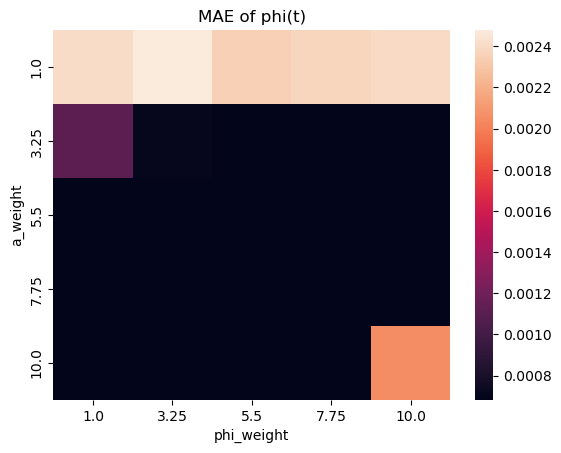

In [89]:
import seaborn as sns
# df_pivot = df.pivot("physics_weight", "ic_weight", "mae_phi")
df_pivot = df.pivot(index="a_weight", columns="phi_weight", values="mae_phi")
sns.heatmap(df_pivot, annot=False, fmt=".2e")
plt.title("MAE of phi(t)")
plt.show()

In [90]:
df

,a_weight,phi_weight,mae_a,mae_phi,pa_weight
0,1.00,1.00,0.021839,0.002409,1.00
1,1.00,3.25,0.022299,0.002479,1.00
2,1.00,5.50,0.021991,0.002351,1.00
3,1.00,7.75,0.021832,0.002381,1.00
4,1.00,10.00,0.021788,0.002396,1.00
5,3.25,1.00,0.015719,0.001112,3.25
6,3.25,3.25,0.015722,0.000705,3.25
7,3.25,5.50,0.015723,0.000683,3.25
8,3.25,7.75,0.015723,0.000683,3.25
9,3.25,10.00,0.015723,0.000683,3.25


In [91]:
best_mae_a_row = df.loc[df['mae_a'].idxmin()]
print("Best (lowest) MAE for a(t):")
print(best_mae_a_row)

Best (lowest) MAE for a(t):
a_weight      10.000000
phi_weight    10.000000
mae_a          0.013429
mae_phi        0.002056
pa_weight     10.000000
Name: 24, dtype: float64


In [92]:
best_mae_phi_row = df.loc[df['mae_phi'].idxmin()]
print("Best (lowest) MAE for phi(t):")
print(best_mae_phi_row)

Best (lowest) MAE for phi(t):
a_weight      3.250000
phi_weight    7.750000
mae_a         0.015723
mae_phi       0.000683
pa_weight     3.250000
Name: 8, dtype: float64


In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot to make a matrix for contouring
pivot_phi = df.pivot(index="a_weight", columns="phi_weight", values="mae_phi")
X, Y = np.meshgrid(pivot_phi.columns.values.astype(float), pivot_phi.index.values.astype(float))
Z = pivot_phi.values.astype(float)

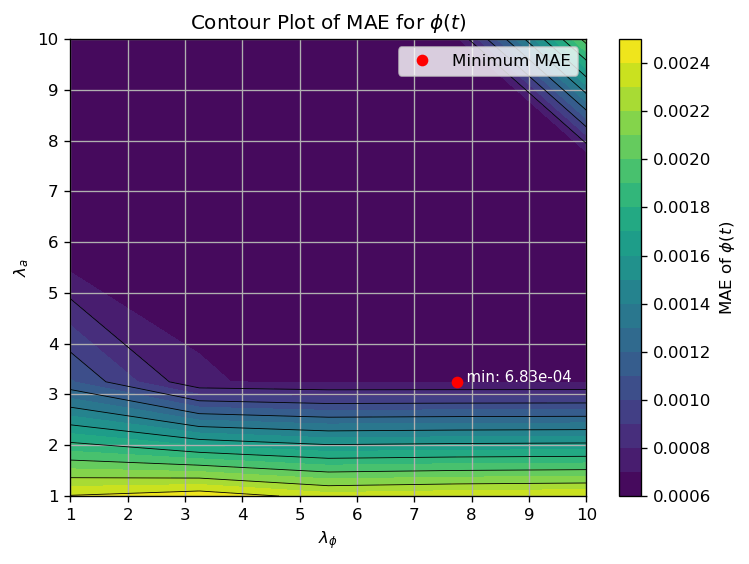

In [98]:
plt.figure(dpi=120)
cp = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(cp, label=r"MAE of $\phi(t)$")
plt.contour(X, Y, Z, levels=10, colors='black', linewidths=0.5)

# Mark the global minimum
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
min_ic = X[min_idx]
min_phys = Y[min_idx]
plt.plot(min_ic, min_phys, 'ro', label='Minimum MAE')
plt.text(min_ic, min_phys, f"  min: {Z[min_idx]:.2e}", color='white', fontsize=9)

plt.xlabel(r"$\lambda_{\phi}$")
plt.ylabel(r"$\lambda_{a}$")
plt.title(r"Contour Plot of MAE for $\phi(t)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot to make a matrix for contouring
pivot_a = df.pivot(index="physics_weight", columns="ic_weight", values="mae_a")
X, Y = np.meshgrid(pivot_a.columns.values.astype(float), pivot_a.index.values.astype(float))
Z = pivot_a.values.astype(float)

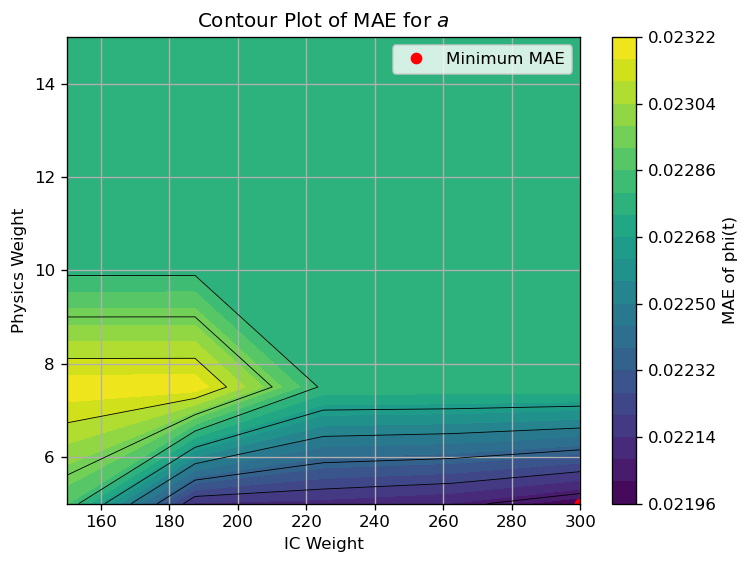

In [29]:
plt.figure(dpi=120)
cp = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(cp, label="MAE of phi(t)")
plt.contour(X, Y, Z, levels=10, colors='black', linewidths=0.5)

# Mark the global minimum
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
min_ic = X[min_idx]
min_phys = Y[min_idx]
plt.plot(min_ic, min_phys, 'ro', label='Minimum MAE')
plt.text(min_ic, min_phys, f"  min: {Z[min_idx]:.2e}", color='white', fontsize=9)

plt.xlabel("IC Weight")
plt.ylabel("Physics Weight")
plt.title(r"Contour Plot of MAE for $a$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()